<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>


**Integrantes**:
* Felipe Santander (201104528-9)
* Miguel Ibáñez (2990010-8)

secciones:

[1.](#primero) Red Neuronal *Feed Forward* para Detectar Exoplanetas  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Redes Convolucionales en Imágenes  
[4.](#cuarto) CNN *vs* RNN Prediciendo el Ozono Atmosférico

In [4]:
!git clone https://github.com/mibanez-parraguez/INF395-Tarea1.git

Cloning into 'INF395-Tarea1'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 9), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [5]:
%cd INF395-Tarea1

/content/INF395-Tarea1


In [6]:
!ls

 Enunciado_T1.ipynb   koi_light_curves_X.csv   ozone_data.csv  'Tarea 1.ipynb'
 koi_labels.csv       koi_sets_unb.csv	       README.md


**Librerias**

In [7]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Dense
from keras.regularizers import l1,l2
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

Using TensorFlow backend.


<a id="primero"></a>
## 1. Red Neuronal *Feed Forward* para Detectar Exoplanetas

**Lectura de datos**

In [0]:
df_sets = pd.read_csv("./koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
df_labels = pd.read_csv("./koi_labels.csv")
df_X = pd.read_csv("./koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]

y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values # vector categorico (1 o 0)
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
nan_X_train = df_X_train.isna().sum() # Sumario de datos nulos
nan_X_test = df_X_test.isna().sum()
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:].astype(dtype=np.float64) # Quita encabezado de las columnas
X_test = df_X_test.values[:,1:].astype(dtype=np.float64)

**a) Descripción data.**



In [18]:
print("confirmados (clase 1): {}\nno confirmados (cl 0): {}".format(sum(y_train), len(y_train)-sum(y_train)))

confirmados (clase 1): 1421
no confirmados (cl 0): 2333


In [43]:
print(df_X_train.columns[1:])
print(df_X_train.columns.shape)

# print(df_X_train.describe())

for i in range(0, 30, 10):
  print(df_X_train.iloc[:,i:i+10].describe())
print(df_X_train.iloc[:,30:].describe())

Index(['Minimum', 'Maximum', 'Mean', 'Std', 'IQR', 'Skew', 'Kurtosis', 'Q1',
       'Q2', 'Slope', 'Amplitude', 'MAD', 'Residual Bright Faint Ratio',
       'Median', 'Period', 'Time of Transit Epoch', 'First Transit Time (BJD)',
       'Impact Parameter', 'Duration', 'Transit Depth', 'r/R',
       'Fitted Stellar Density', 'Planet Radius', 'Semi-major Axis',
       'Inclination', 'Teq', 'Insolation Flux', 'a/R', 'Limb Darkening Coeff1',
       'Limb Darkening Coeff2', 'Limb Darkening Coeff3',
       'Limb Darkening Coeff4', 'Teff', 'log(g)', 'Metallicity',
       'Stellar Radius', 'Stellar Mass', 'Max single event sigma',
       'Max Multievent sigma', 'Transit Model SNR', 'KOI count'],
      dtype='object')
(42,)

[0:10]
           Minimum      Maximum         Mean          Std          IQR  \
count  4692.000000  4692.000000  4692.000000  4692.000000  4692.000000   
mean    -66.492676    23.987692    -0.142418     4.136842     0.333109   
std     274.391875   112.019945     0.501607 

Atributos 1 al 10
 1: Minimum                          6: Skew                        
 2: Maximum                          7: Kurtosis                    
 3: Mean                             8: Q1                          
 4: Std                              9: Q2                          
 5: IQR                             10: Slope                       


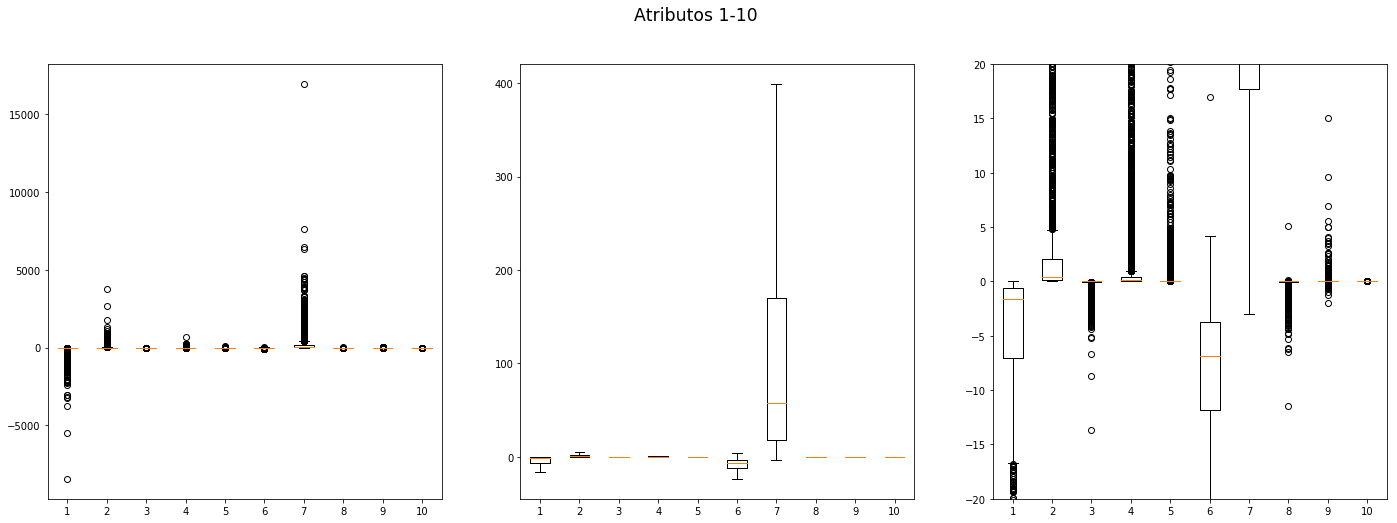




Atributos 11 al 20
11: Amplitude                       16: Time of Transit Epoch       
12: MAD                             17: First Transit Time (BJD)    
13: Residual Bright Faint Ratio     18: Impact Parameter            
14: Median                          19: Duration                    
15: Period                          20: Transit Depth               


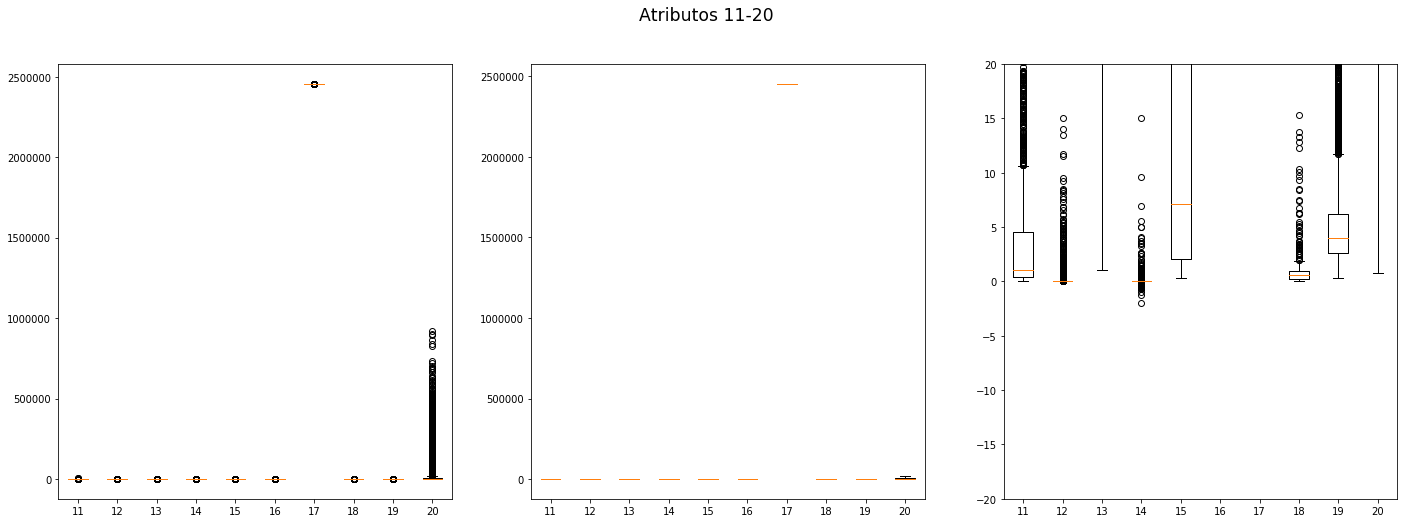




Atributos 21 al 30
21: r/R                             26: Teq                         
22: Fitted Stellar Density          27: Insolation Flux             
23: Planet Radius                   28: a/R                         
24: Semi-major Axis                 29: Limb Darkening Coeff1       
25: Inclination                     30: Limb Darkening Coeff2       


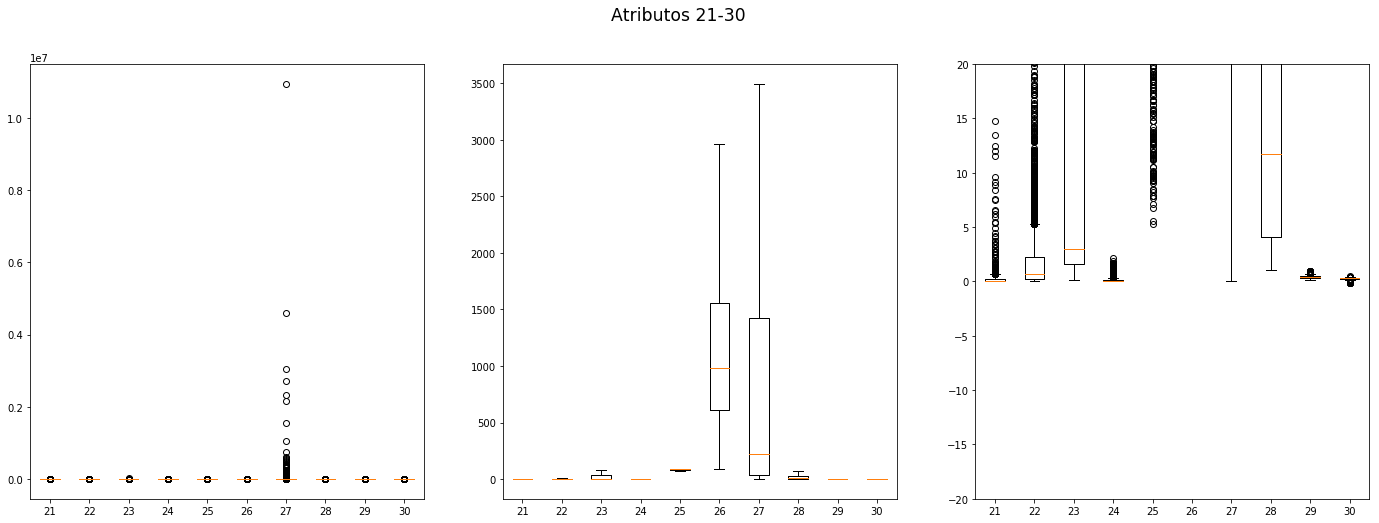




Atributos 31 al 41
31: Limb Darkening Coeff3           36: Stellar Radius              
32: Limb Darkening Coeff4           37: Stellar Mass                
33: Teff                            38: Max single event sigma      
34: log(g)                          39: Max Multievent sigma        
35: Metallicity                     40: Transit Model SNR           
                                    41: KOI count                   


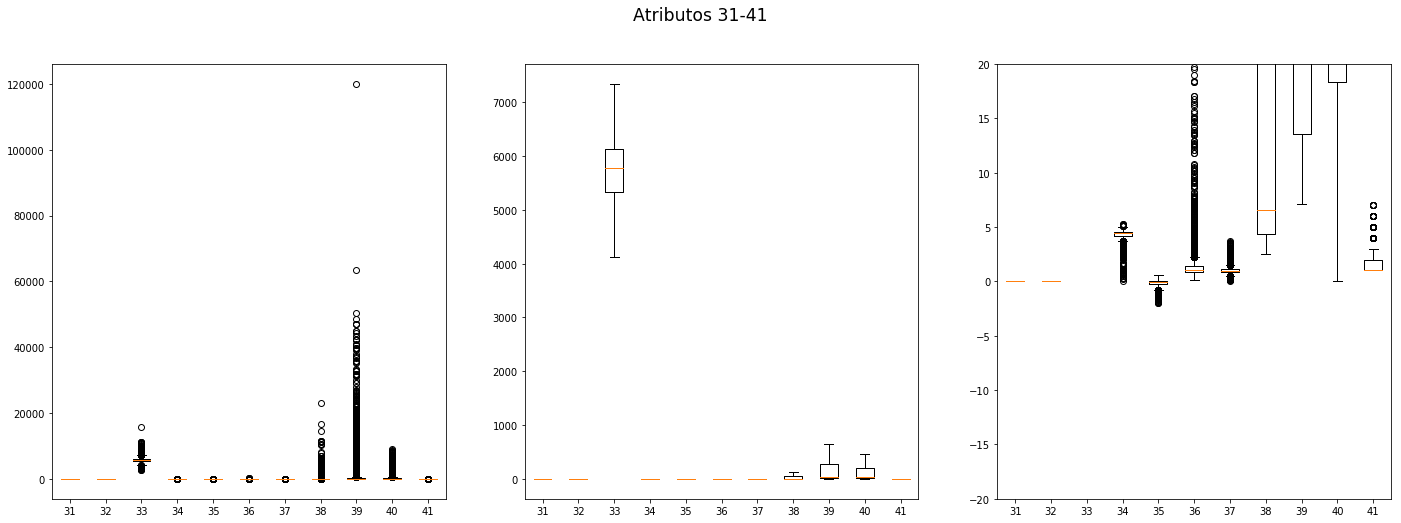

In [56]:
cols = df_X_train.columns[1:]

print("Atributos 1 al 10")
for k in range(5):
  print("{:>2}: {:<28s}    {:>2}: {:<28s}".format(k+1, cols[k], k+6, cols[k+5]))
fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 1-10", fontsize='xx-large')
axes[0].boxplot(X_train[:,0:10])
axes[1].boxplot(X_train[:,0:10], sym="")
axes[2].boxplot(X_train[:,0:10])
axes[2].set_ylim(-20,20)
plt.show()


print("\n\n\nAtributos 11 al 20")
for k in range(10,15):
  print("{:>2}: {:<28s}    {:>2}: {:<28s}".format(k+1, cols[k], k+6, cols[k+5]))
fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 11-20", fontsize='xx-large')
axes[0].boxplot(X_train[:,10:20], labels=range(11,21))
axes[1].boxplot(X_train[:,10:20], labels=range(11,21), sym="")
axes[2].boxplot(X_train[:,10:20], labels=range(11,21))
axes[2].set_ylim(-20,20)
plt.show()


print("\n\n\nAtributos 21 al 30")
for k in range(20,25):
  print("{:>2}: {:<28s}    {:>2}: {:<28s}".format(k+1, cols[k], k+6, cols[k+5]))
fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 21-30", fontsize='xx-large')
axes[0].boxplot(X_train[:,20:30], labels=range(21,31))
axes[1].boxplot(X_train[:,20:30], labels=range(21,31), sym="")
axes[2].boxplot(X_train[:,20:30], labels=range(21,31))
axes[2].set_ylim(-20,20)
plt.show()


print("\n\n\nAtributos 31 al 41")
for k in range(30,35):
  print("{:>2}: {:<28s}    {:>2}: {:<28s}".format(k+1, cols[k], k+6, cols[k+5]))
print("{}{:>2}: {:<28s}".format(" "*36,41, cols[40]))
fig, axes = plt.subplots(1,3, figsize=(24,8))
fig.suptitle("Atributos 31-41", fontsize='xx-large')
axes[0].boxplot(X_train[:,30:], labels=range(31,42))
axes[1].boxplot(X_train[:,30:], labels=range(31,42), sym="")
axes[2].boxplot(X_train[:,30:], labels=range(31,42))
axes[2].set_ylim(-20,20)
plt.show()

Problema de transformar un vector $X$ en un valor categórico (0 o 1).

- Los atributos están en distinta escala?
- Muchos atributos (dimensiones)
- No es simple determinar la importancia de cada atributo para formar un modelo.

**b) Escalamiento.**

Ayuda a tener una varianza similar entre los distintos atributos. Un atributo con una varianza de ordenes de magnitud mayor al resto de los atributos, puede tener una influencia mayor que el resto en el modelo independiente de la importancia real del atributo.


In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test) # ???
X_test_scaled =  scaler.transform(X_test)

Conjunto de validación, manteniendo desbalanceo

Se extrae el 20% de elementos de cada clase (*confirmed* y *no confirmed*)

In [0]:
# Conjunto validacion
n_cl1 =int(sum(y_train)*.2)
n_cl0 =int((len(y_train)-sum(y_train))*.2)
idx_cl1 = np.random.choice(np.arange(len(y_train))[y_train.astype(dtype=bool)], n_cl1, replace=False)
idx_cl0 = np.random.choice(np.arange(len(y_train))[np.logical_not(y_train)], n_cl0, replace=False)

X_val_scaled = np.append(X_train_scaled[idx_cl1], X_train_scaled[idx_cl0], axis=0)
y_val = np.ones(n_cl1 + n_cl0)
y_val[n_cl1:] = 0

# Saca del conjunto de entrenamiento los elementos que ahora estan en validacion
idx_aux = np.ones(len(y_train), dtype=bool)
idx_aux[idx_cl1] = False
idx_aux[idx_cl0] = False
X_train_scaled = X_train_scaled[idx_aux]
y_train = y_train[idx_aux]

**c) sigmoid vs relu**

In [0]:
from matplotlib.lines import Line2D

def plotModel(N, mid_activ, optim, batchsz=None, l1=None, l2=None, eps=100, title=None, text=None):
    model = None
    model_best = None
    model_worst = None
    vloss_best = 999
    vloss_worst = 0
    fig, ax = plt.subplots(1, 1, figsize=(20,8))
    for i in range(N):
        model = Sequential()
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], 
                        kernel_initializer='uniform', activation=mid_activ, 
                        kernel_regularizer=l2, activity_regularizer=l1))
        model.add(Dense(1, kernel_initializer='uniform', activation="sigmoid", 
                        kernel_regularizer=l2, activity_regularizer=l1))
        model.compile(optimizer=optim, loss='binary_crossentropy')
        hist = model.fit(X_train_scaled, y_train, batch_size=batchsz, epochs=eps, verbose=0, validation_data=(X_val_scaled, y_val))
        if hist.history["val_loss"][-1] < vloss_best:
            model_best = model
            vloss_best = hist.history["val_loss"][-1]
        if hist.history["val_loss"][-1] > vloss_worst:
            model_worst = model
            vloss_worst = hist.history["val_loss"][-1]
        ax.plot(range(eps), hist.history["loss"], 'o')
        ax.plot(range(eps), hist.history["val_loss"], 'x')
    ax.set_ylabel('Loss')
    ax.set_xlabel('epoch')
    ax.text(0.85, 0.80, 'Activation: {}'.format(mid_activ), transform=ax.transAxes, fontsize="large")
    h = (Line2D([], [], lw=0, color='green', marker="o", markersize=10), 
         Line2D([], [], lw=0, color='blue', marker='x', markersize=10))
    l = ("Train set", "Validation")
    ax.legend(h, l, loc='upper left', bbox_to_anchor=(0.84, 0.98), fontsize='x-large')
    if(title):
        ax.set_title(title, fontsize='xx-large')
    else:
        ax.set_title("Cross Entropy Loss vs epoch", fontsize='xx-large')
    if(text):
        # INFO text => array [dict {x: coord_x, y: coord_y, txt: texto, kw: **kwargs}]
        for tx in text:
            ax.text(tx['x'], tx['y'], tx['txt'], transform=ax.transAxes, **tx["kw"])
    plt.show()
    return model_best, model_worst

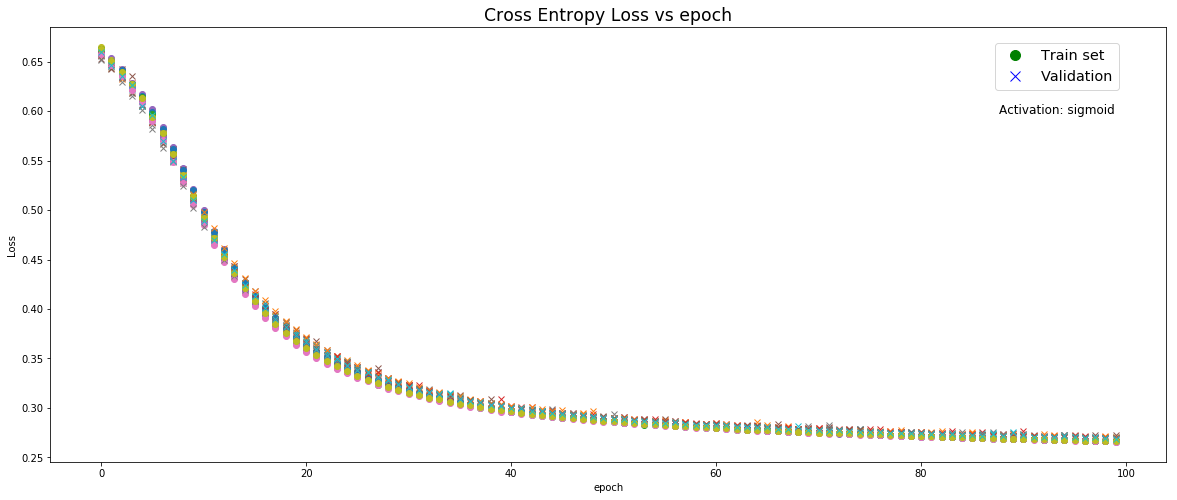

In [65]:
# Sigmoid
model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01))
print()

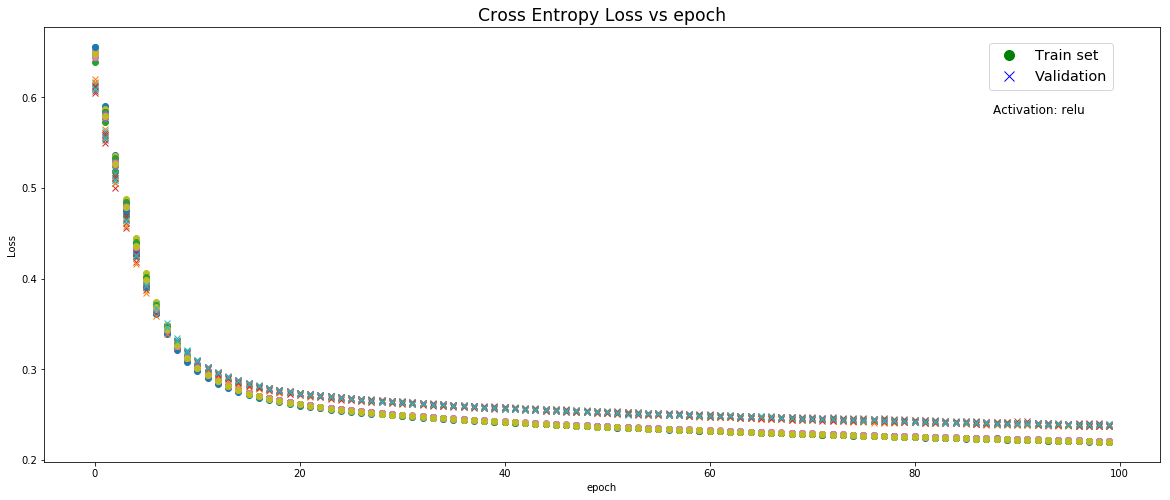

In [66]:
# ReLu
model_relu = plotModel(10, "relu", SGD(lr=0.01))

Metrica f1

In [68]:
f1_sigm = f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')
f1_relu = f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')

print("f1 score (sigmoid): {}".format(f1_sigm))
print("   f1 score (relu): {}".format(f1_relu))

f1 score (sigmoid): 0.8405588176951314
   f1 score (relu): 0.8576009105164563


**d)  Tasa de aprendizaje**

In [0]:
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)

for lrn in learn_rate:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: {:.2g}".format(lrn), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/Learning rate: {:.2g}".format(lrn)
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=lrn), title=title, text=txt)
    model_relu = plotModel(10, "relu", SGD(lr=lrn), title=title, text=txt)

**e) _Progressive decay_**

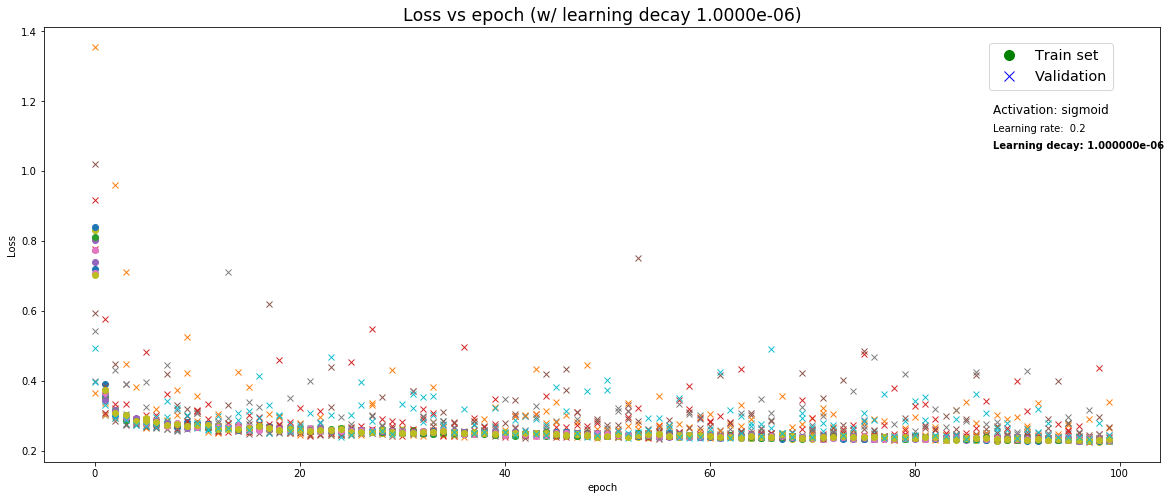

f1 score (sigmoid; decay 1.000000e-06): 0.7810350260334575





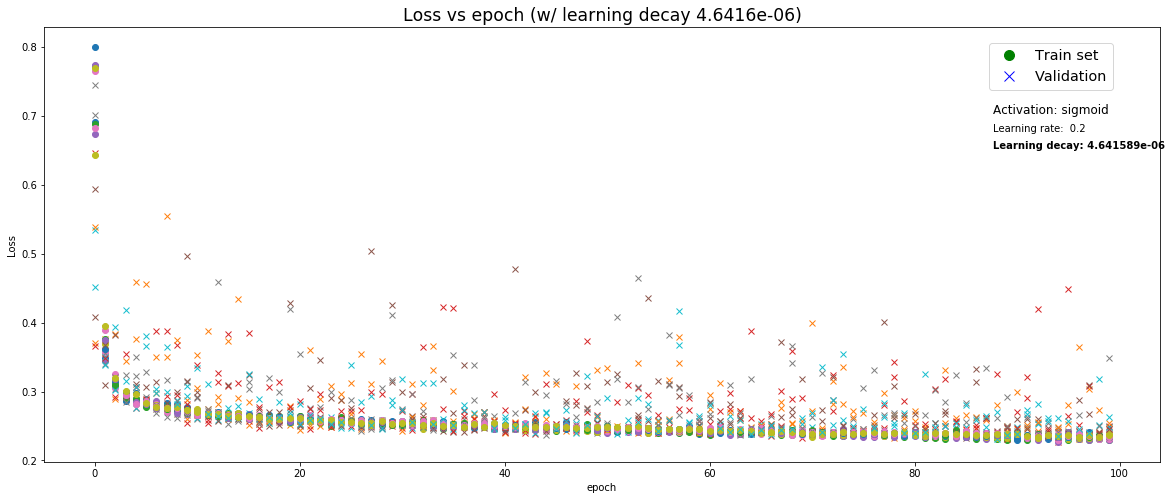

f1 score (sigmoid; decay 4.641589e-06): 0.7810073980817701





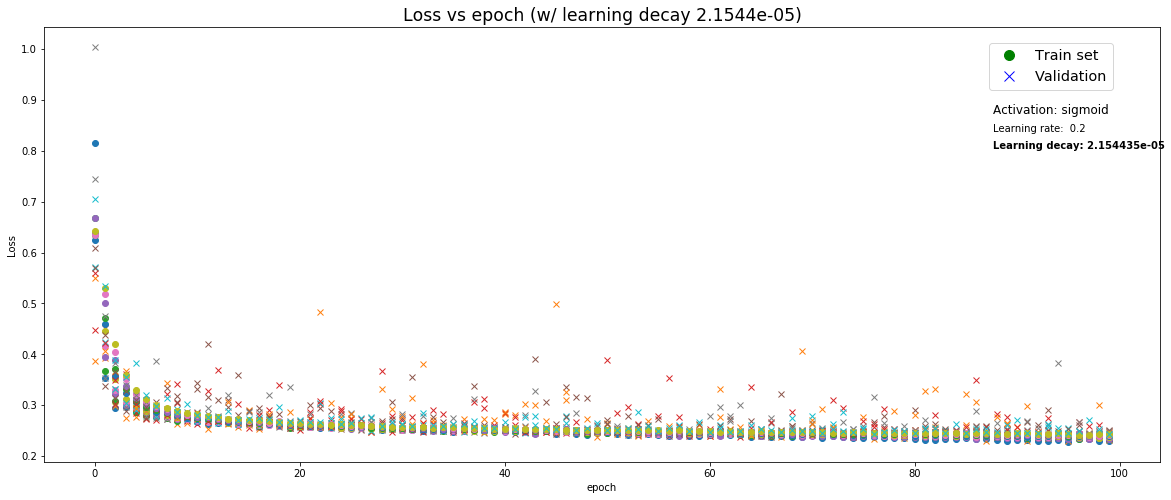

f1 score (sigmoid; decay 2.154435e-05): 0.7834818907588121





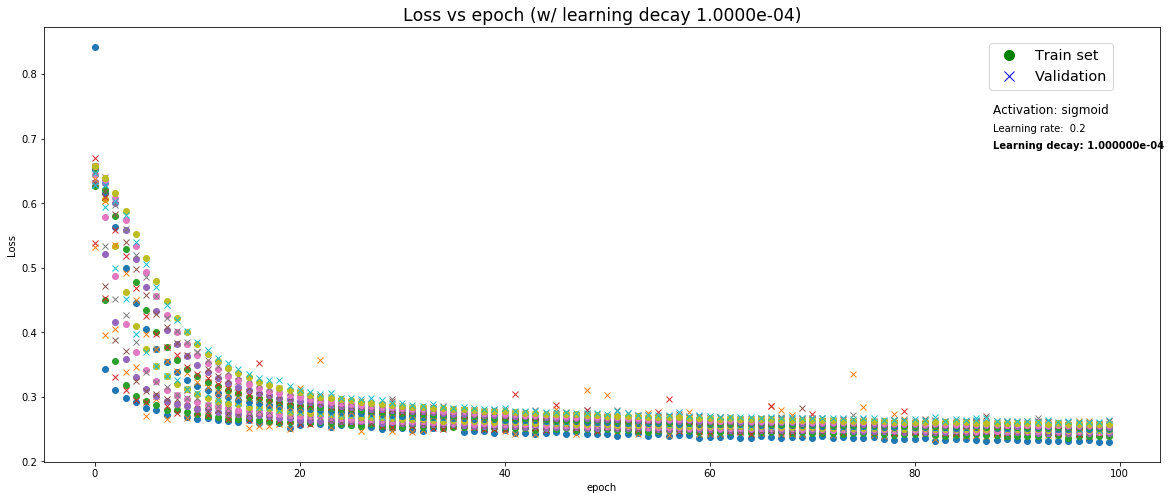

f1 score (sigmoid; decay 1.000000e-04): 0.7816600082262859





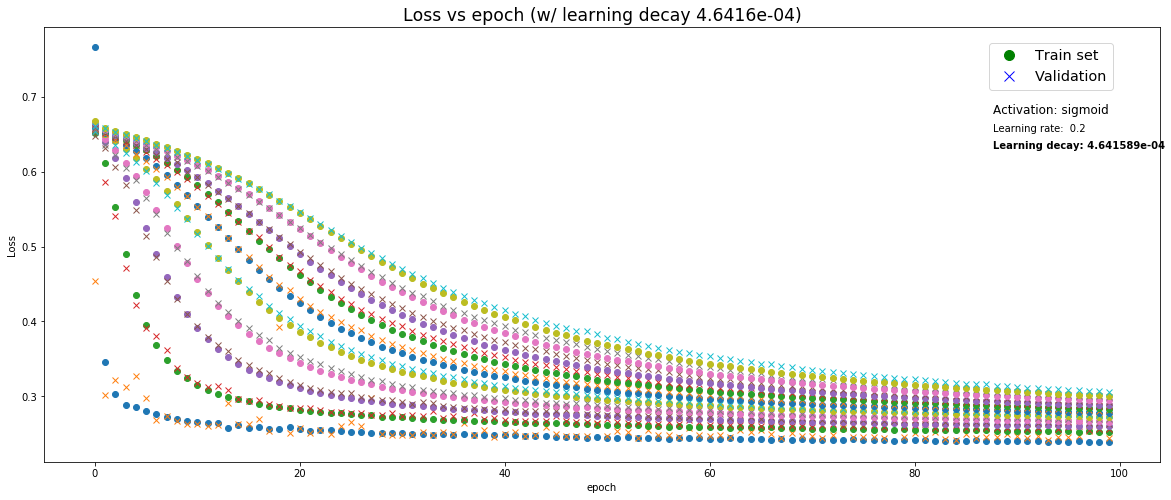

f1 score (sigmoid; decay 4.641589e-04): 0.8205092094741988





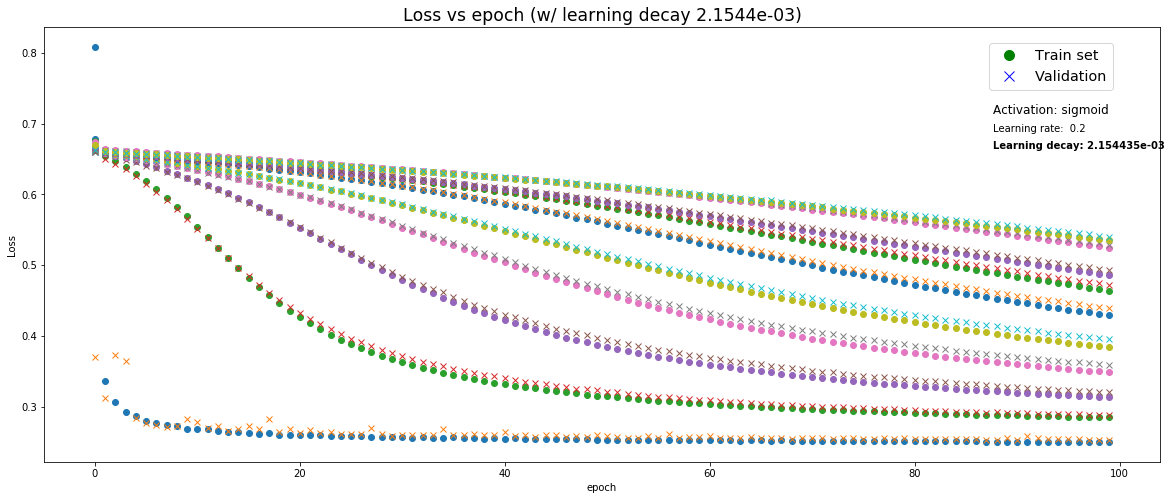

f1 score (sigmoid; decay 2.154435e-03): 0.840411759235401





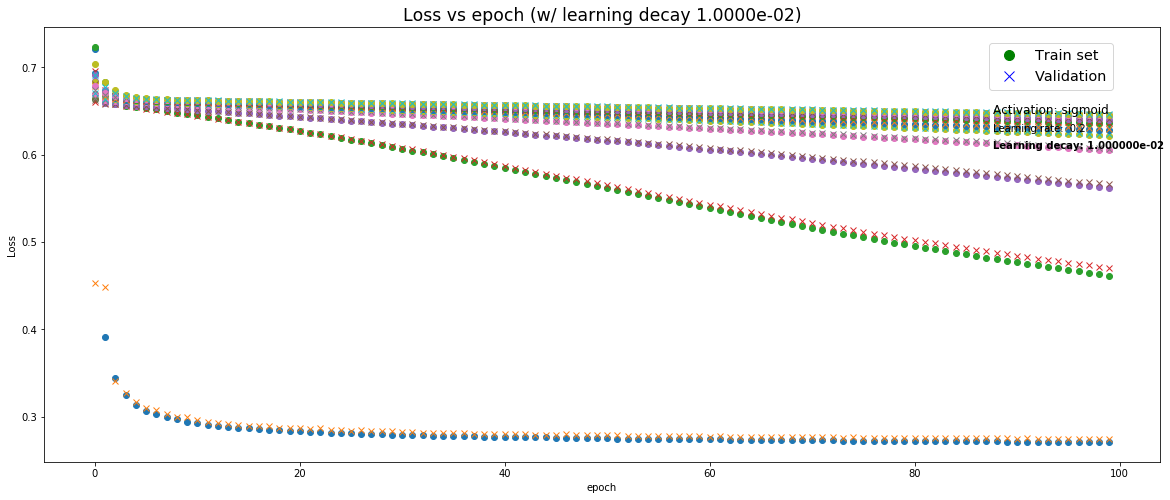

f1 score (sigmoid; decay 1.000000e-02): 0.8369680272163043





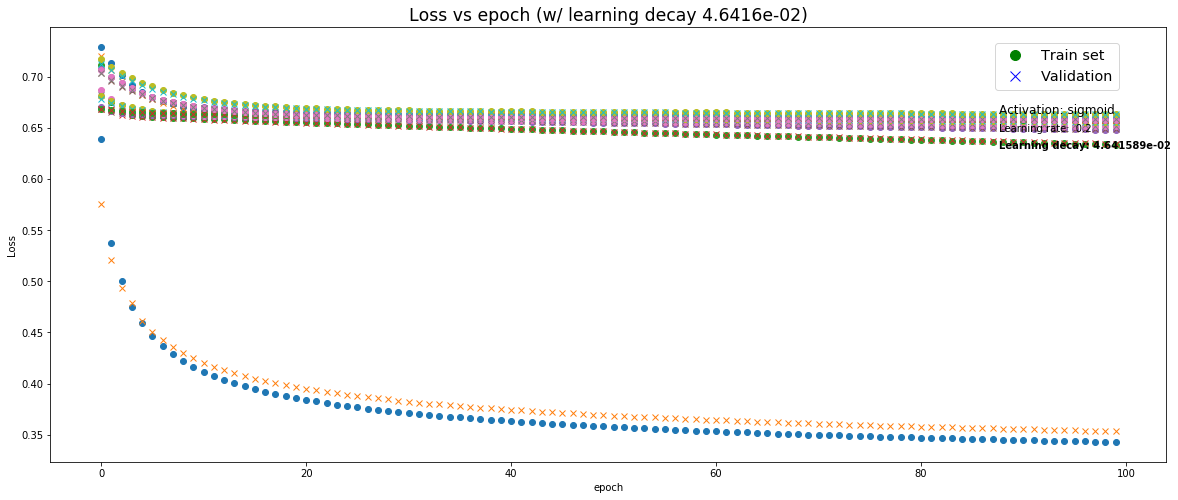

f1 score (sigmoid; decay 4.641589e-02): 0.816600583516546





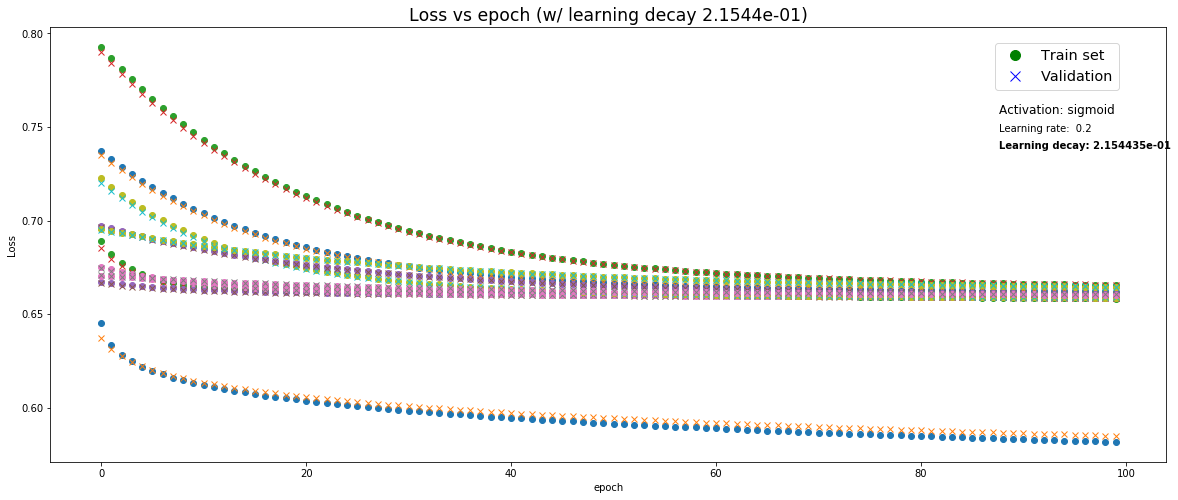

f1 score (sigmoid; decay 2.154435e-01): 0.5829811835812214





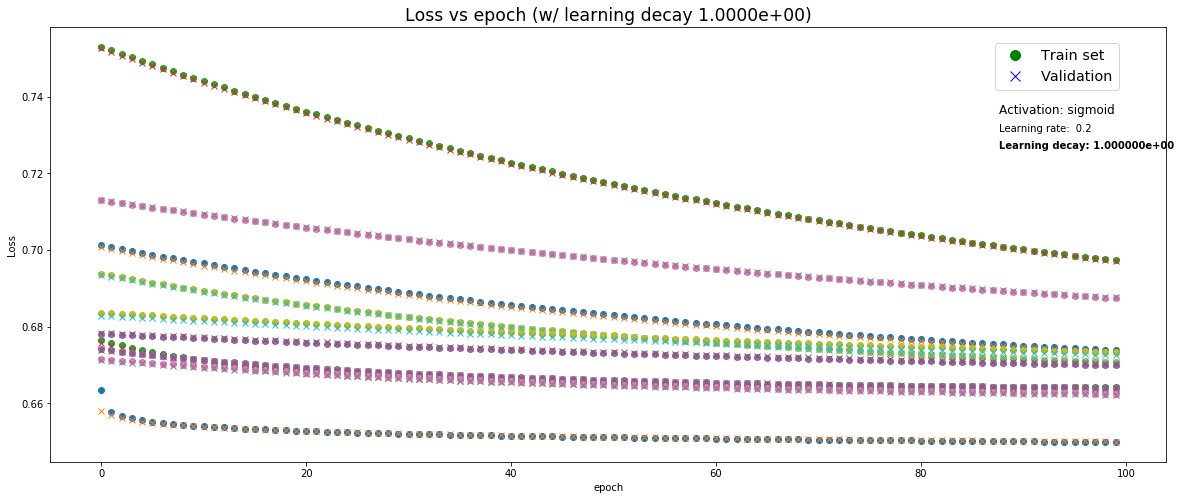

f1 score (sigmoid; decay 1.000000e+00): 0.5470135402403773





/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)


for lrd in lear_decay:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate:  0.2", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Learning decay: {:4e}".format(lrd), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ learning decay {:.4e})".format(lrd)
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.2, decay=lrd), title=title, text=txt)
    
    print("f1 score (sigmoid; decay {:4e}): {}\n\n\n".format(lrd, f1_score(y_test,model_sigmoid.predict_classes(X_test_scaled),average='weighted')))

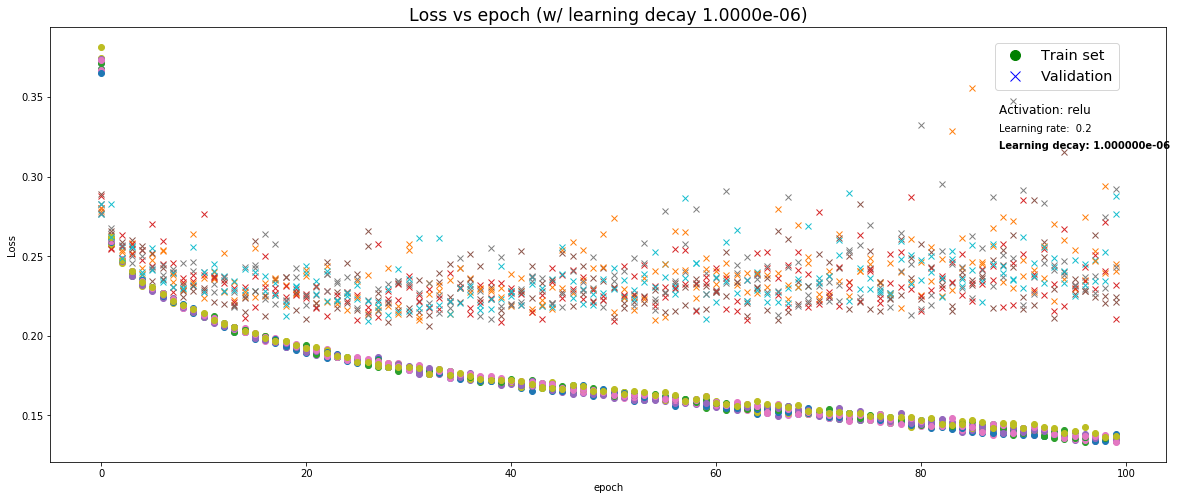

f1 score (relu; decay 1.000000e-06): 0.858355019576009





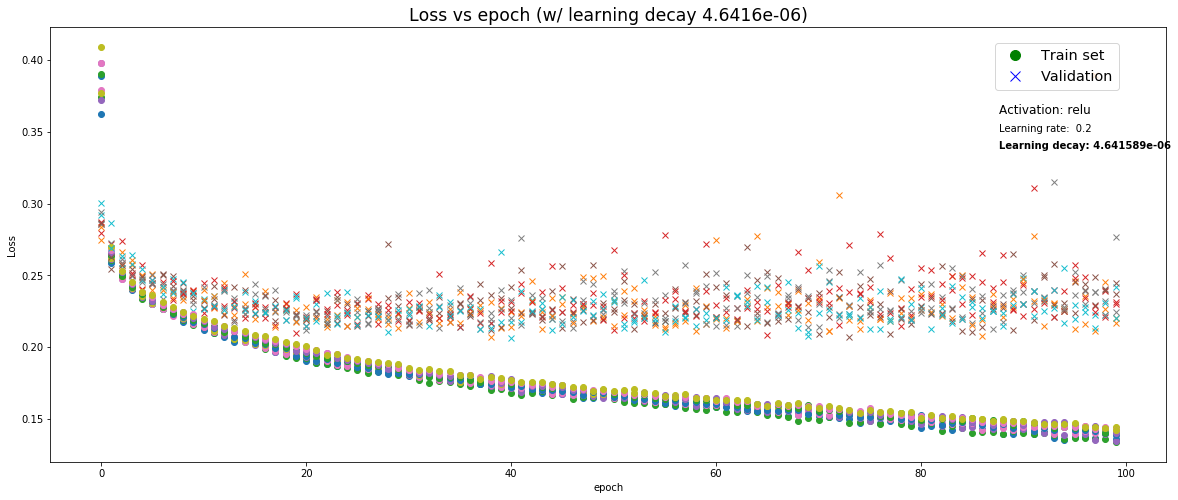

f1 score (relu; decay 4.641589e-06): 0.8463390120440332





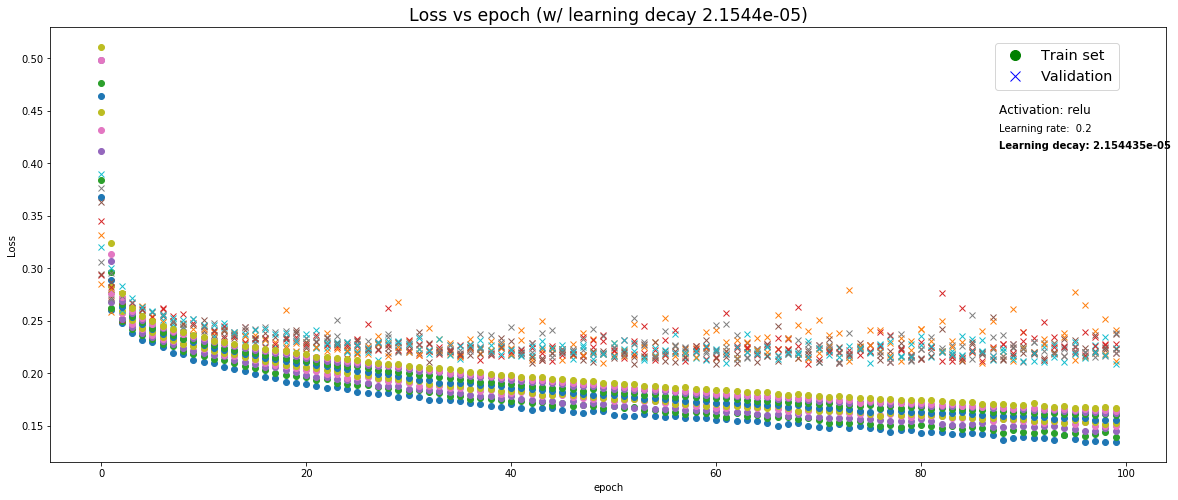

f1 score (relu; decay 2.154435e-05): 0.8396421927232023





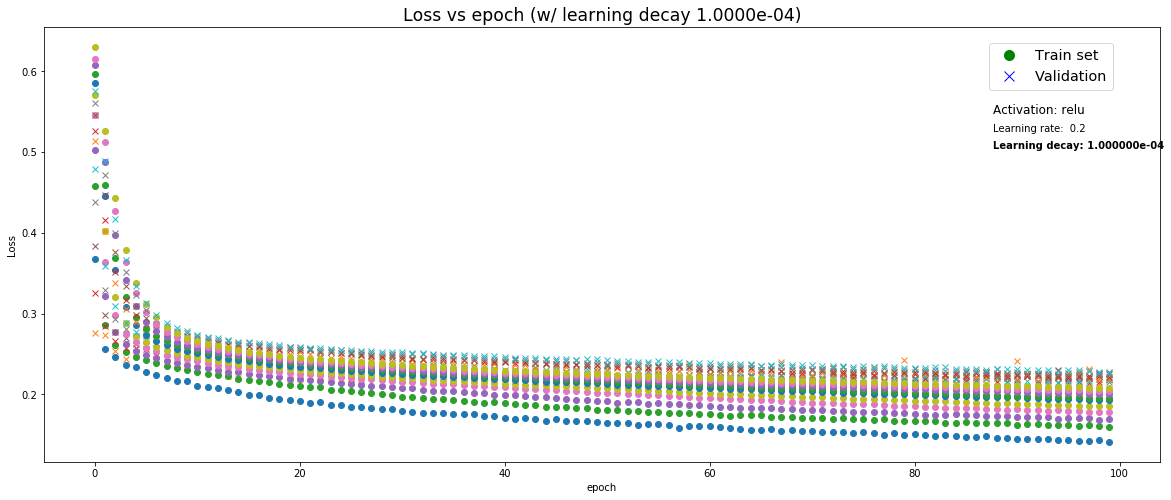

f1 score (relu; decay 1.000000e-04): 0.8493026423765808





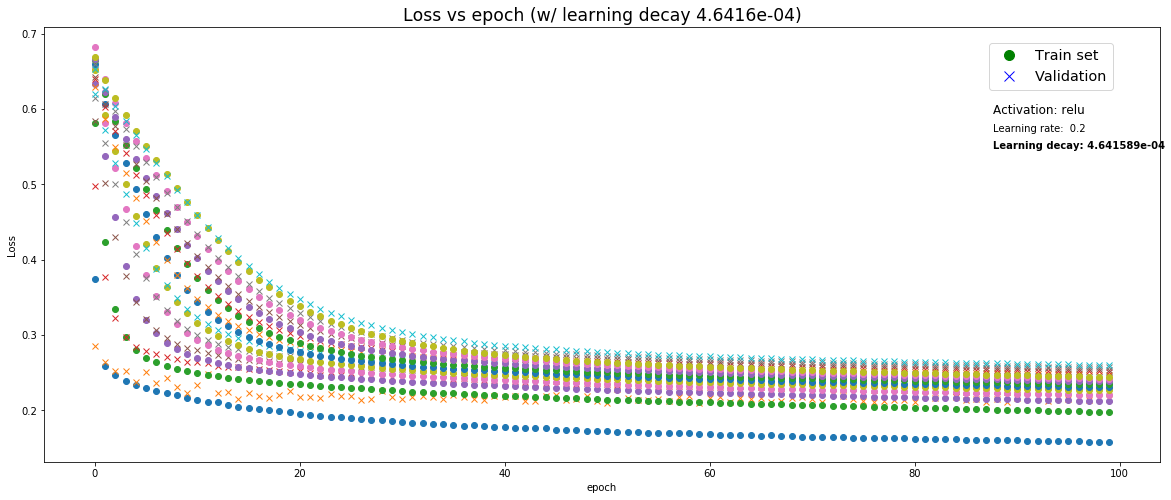

f1 score (relu; decay 4.641589e-04): 0.8444502936561394





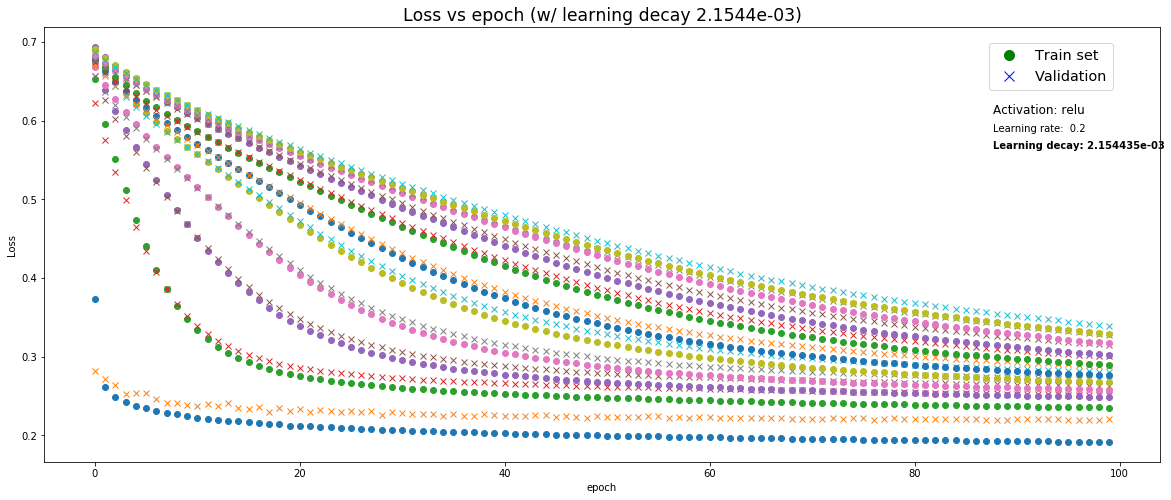

f1 score (relu; decay 2.154435e-03): 0.8521145166512579





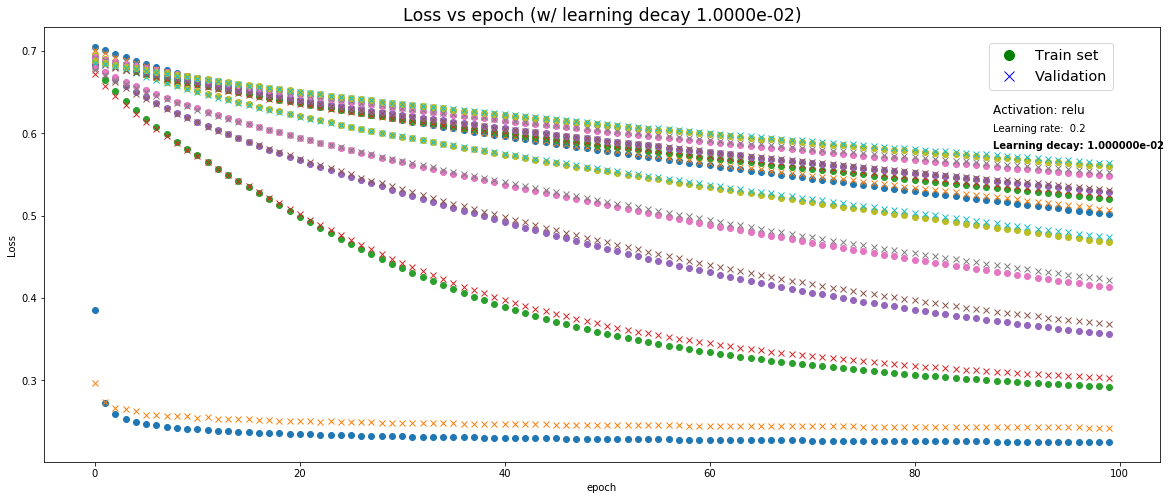

f1 score (relu; decay 1.000000e-02): 0.8524802391511179





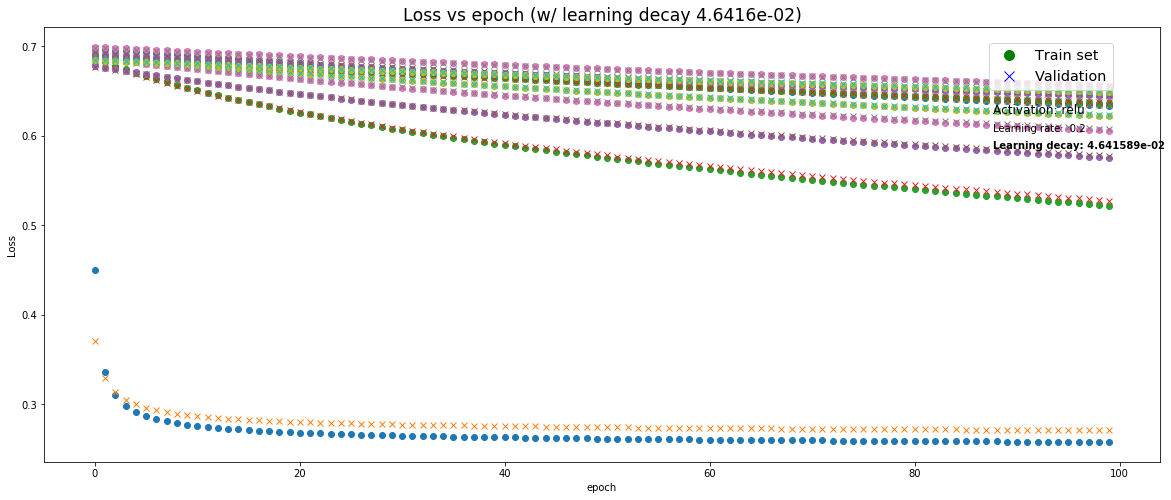

f1 score (relu; decay 4.641589e-02): 0.849708202962708





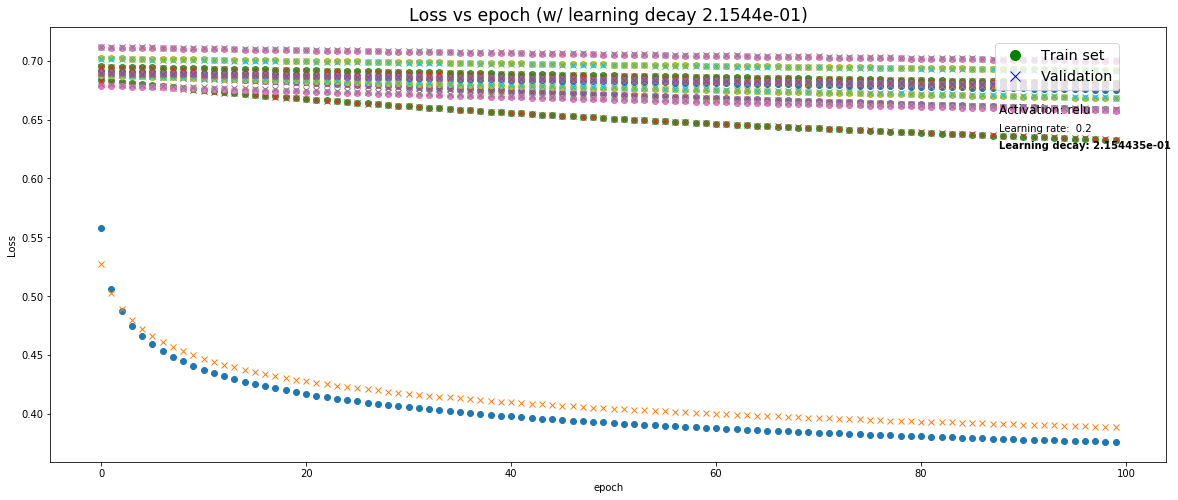

f1 score (relu; decay 2.154435e-01): 0.8117430678732449





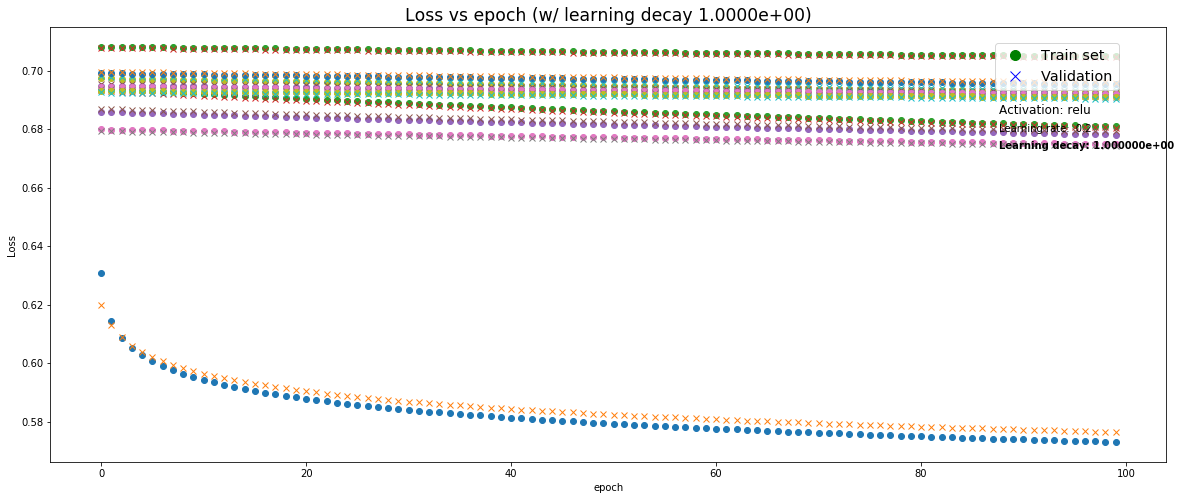

f1 score (relu; decay 1.000000e+00): 0.6253861354899417





In [71]:
for lrd in lear_decay:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate:  0.2", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Learning decay: {:e}".format(lrd), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ learning decay {:.4e})".format(lrd)
    model_relu = plotModel(10, "relu", SGD(lr=0.2, decay=lrd), title=title, text=txt)
    print("f1 score (relu; decay {:4e}): {}\n\n\n".format(lrd, f1_score(y_test,model_relu.predict_classes(X_test_scaled),average='weighted')))

**f) Momentum clásico y momentum de Nesterov**

In [0]:
split_space = 21
momentums = np.linspace(0,1,split_space)
# Momentum clásico
print("Momentum clásico\n================")
for mmt in momentums:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Momentum: {:.2g}".format(mmt), 'kw': {}}, 
           {'x': 0.85, 'y': 0.68, 'txt': "Nesterov: False"}, 'kw': {}]
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01, momentum=mmt, nesterov=False), text=txt)
    model_sigmoid = plotModel(10, "relu", SGD(lr=0.01, momentum=mmt, nesterov=False), text=txt)

In [0]:
# Momentum de nesterov
print("Momentum de nesterov\n=====================")
for mmt in momentums:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}}, 
           {'x': 0.85, 'y': 0.72, 'txt': "Momentum: {:.2g}".format(mmt), 'kw': {}}, 
           {'x': 0.85, 'y': 0.68, 'txt': "Nesterov: True"}, 'kw': {}]
    model_sigmoid = plotModel(10, "sigmoid", SGD(lr=0.01, momentum=mmt, nesterov=True), text=txt)
    model_sigmoid = plotModel(10, "relu", SGD(lr=0.01, momentum=mmt, nesterov=True), text=txt)

**g) Batch size**

In [0]:
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches)).astype(dtype=int)

for bsz in batch_sizes:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
           {'x': 0.85, 'y': 0.72, 'txt': "Batch size: {:n}".format(bsz), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (batch_size: {:n})".format(bsz)
    model_sigmoid = plotModel(4, "sigmoid", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)
    #model_relu = plotModel(4, "relu", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)

In [0]:
for bsz in batch_sizes:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
           {'x': 0.85, 'y': 0.72, 'txt': "Batch size: {:n}".format(bsz), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (batch_size: {:n})".format(bsz)
    model_relu = plotModel(4, "relu", SGD(lr=0.01), batchsz=bsz, title=title, text=txt)

**h) Optimizers: Adam, RMSprop, Adagrad & Adadelta**

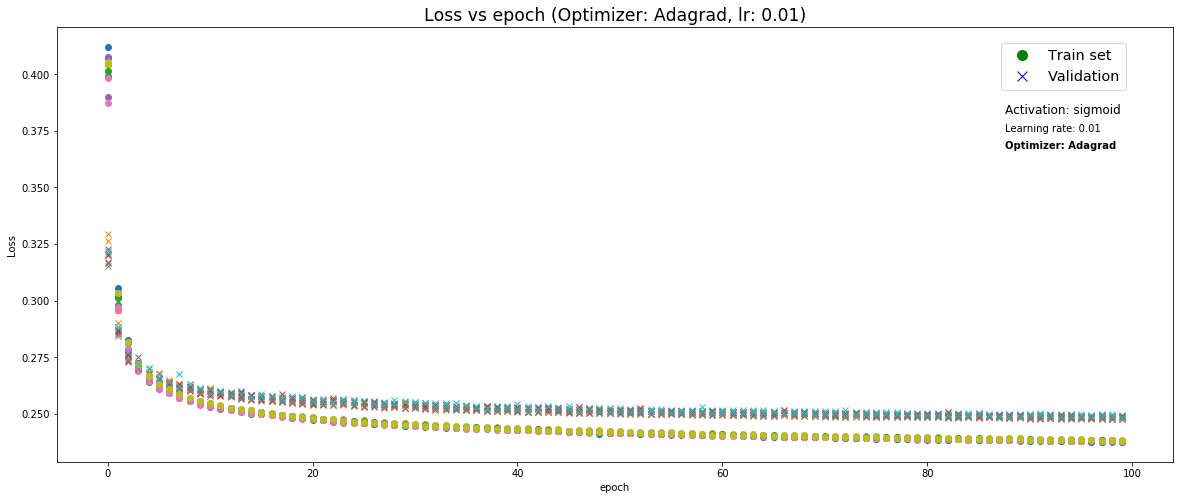

f1 score  (best model; sigmoid; Adagrad): 0.7915896910991641
f1 score (worst model; sigmoid; Adagrad): 0.8089621630867





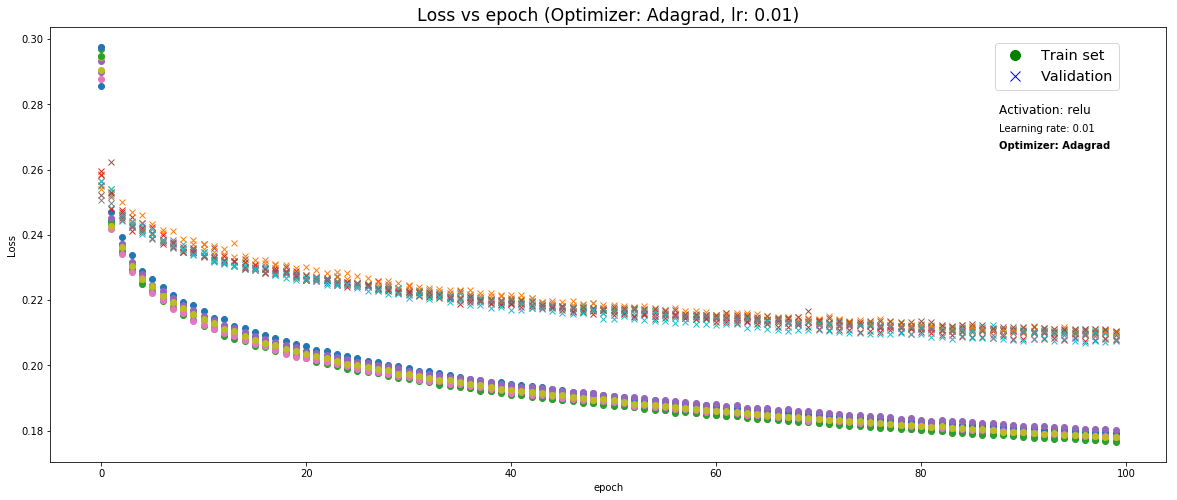

f1 score  (best model; relu; Adagrad): 0.7990509377267678
f1 score (worst model; relu; Adagrad): 0.802156024550258


In [13]:
# Adagrad

txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
       {'x': 0.85, 'y': 0.72, 'txt': "Optimizer: Adagrad", 'kw': {'weight': 'bold'}}]
title = "Loss vs epoch (Optimizer: Adagrad, lr: 0.01)"


model_sigmoid = plotModel(10, "sigmoid", Adagrad(lr=0.01), title=title, text=txt)
print("f1 score  (best model; sigmoid; Adagrad): {}".format(f1_score(y_test,model_sigmoid[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; sigmoid; Adagrad): {}\n\n\n".format(f1_score(y_test,model_sigmoid[1].predict_classes(X_test_scaled),average='weighted')))

model_relu = plotModel(10, "relu", Adagrad(lr=0.01), title=title, text=txt)
print("f1 score  (best model; relu; Adagrad): {}".format(f1_score(y_test,model_relu[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; relu; Adagrad): {}".format(f1_score(y_test,model_relu[1].predict_classes(X_test_scaled),average='weighted')))

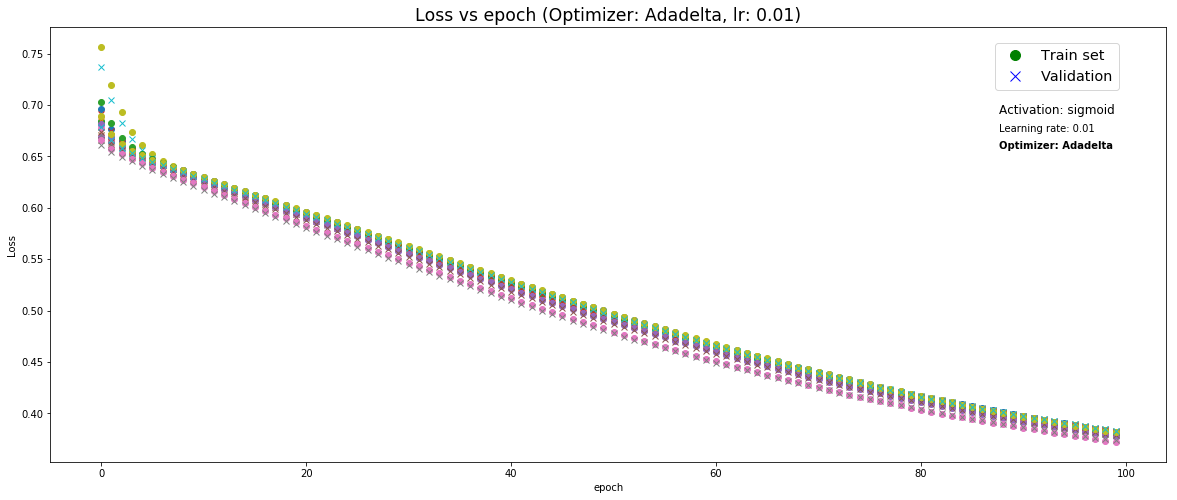

f1 score  (best model; sigmoid; Adadelta): 0.8082570933833843
f1 score (worst model; sigmoid; Adadelta): 0.8095220540454299





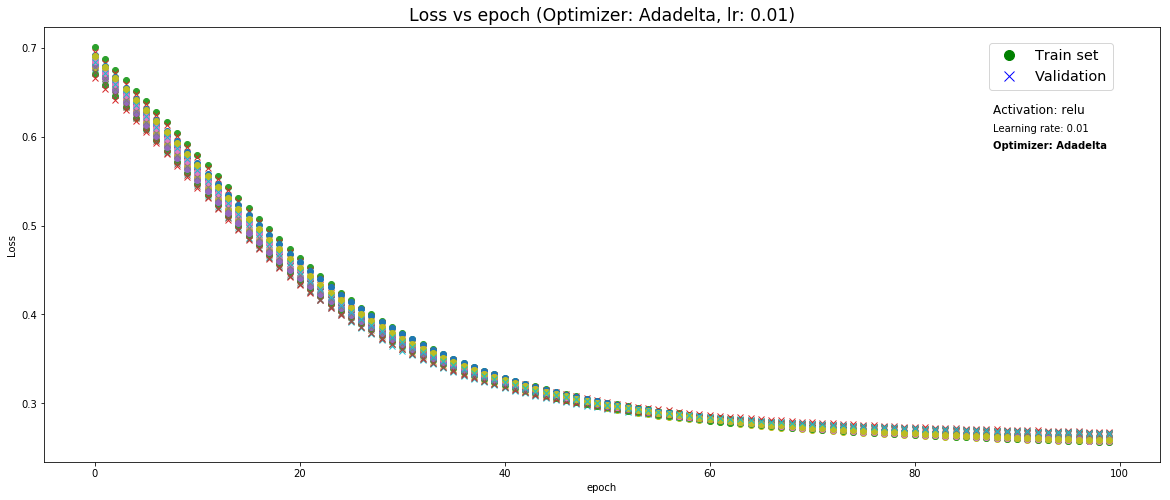

f1 score  (best model; relu; Adadelta): 0.8442406531594425
f1 score (worst model; relu; Adadelta): 0.8424788994325496


In [14]:
# Adadelta
txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
       {'x': 0.85, 'y': 0.72, 'txt': "Optimizer: Adadelta", 'kw': {'weight': 'bold'}}]
title = "Loss vs epoch (Optimizer: Adadelta, lr: 0.01)"


model_sigmoid = plotModel(10, "sigmoid", Adadelta(lr=0.01), title=title, text=txt)
print("f1 score  (best model; sigmoid; Adadelta): {}".format(f1_score(y_test,model_sigmoid[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; sigmoid; Adadelta): {}\n\n\n".format(f1_score(y_test,model_sigmoid[1].predict_classes(X_test_scaled),average='weighted')))

model_relu = plotModel(10, "relu", Adadelta(lr=0.01), title=title, text=txt)
print("f1 score  (best model; relu; Adadelta): {}".format(f1_score(y_test,model_relu[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; relu; Adadelta): {}".format(f1_score(y_test,model_relu[1].predict_classes(X_test_scaled),average='weighted')))

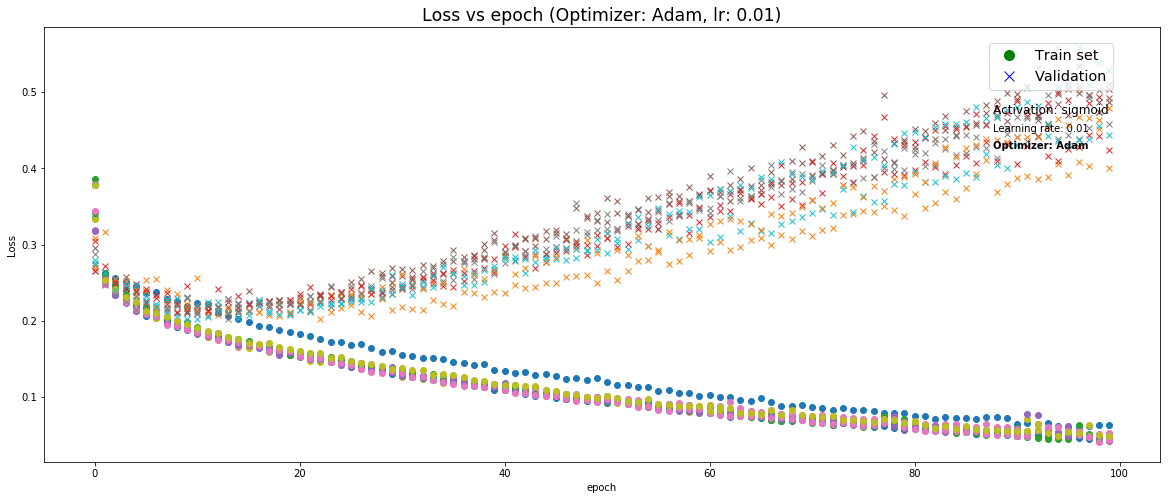

f1 score  (best model; sigmoid; Adam): 0.7854332441876635
f1 score (worst model; sigmoid; Adam): 0.7897907760846491





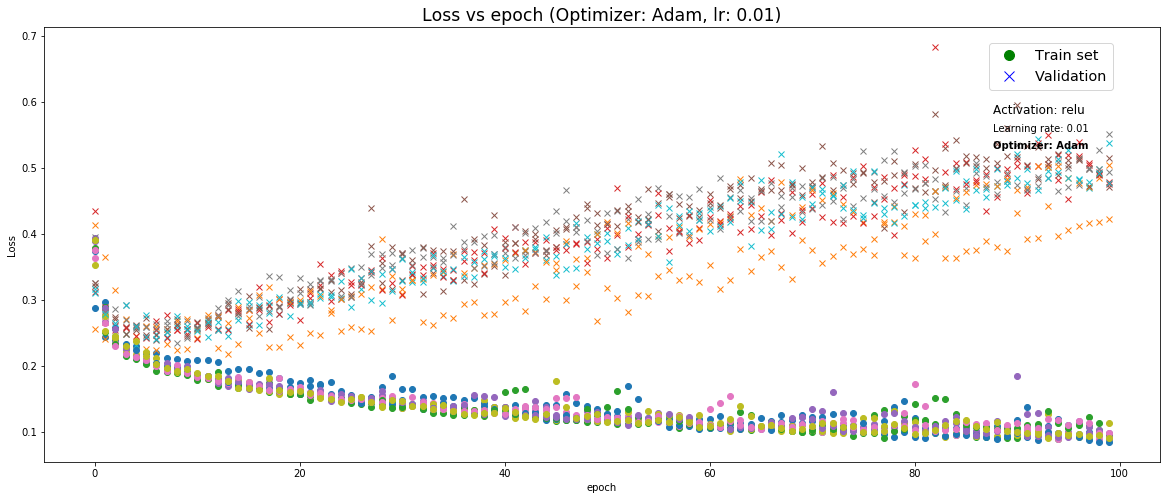

f1 score  (best model; relu; Adam): 0.8314894472212229
f1 score (worst model; relu; Adam): 0.8015002302154306


In [15]:
# Adam
txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
       {'x': 0.85, 'y': 0.72, 'txt': "Optimizer: Adam", 'kw': {'weight': 'bold'}}]
title = "Loss vs epoch (Optimizer: Adam, lr: 0.01)"


model_sigmoid = plotModel(10, "sigmoid", Adam(lr=0.01), title=title, text=txt)
print("f1 score  (best model; sigmoid; Adam): {}".format(f1_score(y_test,model_sigmoid[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; sigmoid; Adam): {}\n\n\n".format(f1_score(y_test,model_sigmoid[1].predict_classes(X_test_scaled),average='weighted')))

model_relu = plotModel(10, "relu", Adam(lr=0.01), title=title, text=txt)
print("f1 score  (best model; relu; Adam): {}".format(f1_score(y_test,model_relu[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; relu; Adam): {}".format(f1_score(y_test,model_relu[1].predict_classes(X_test_scaled),average='weighted')))

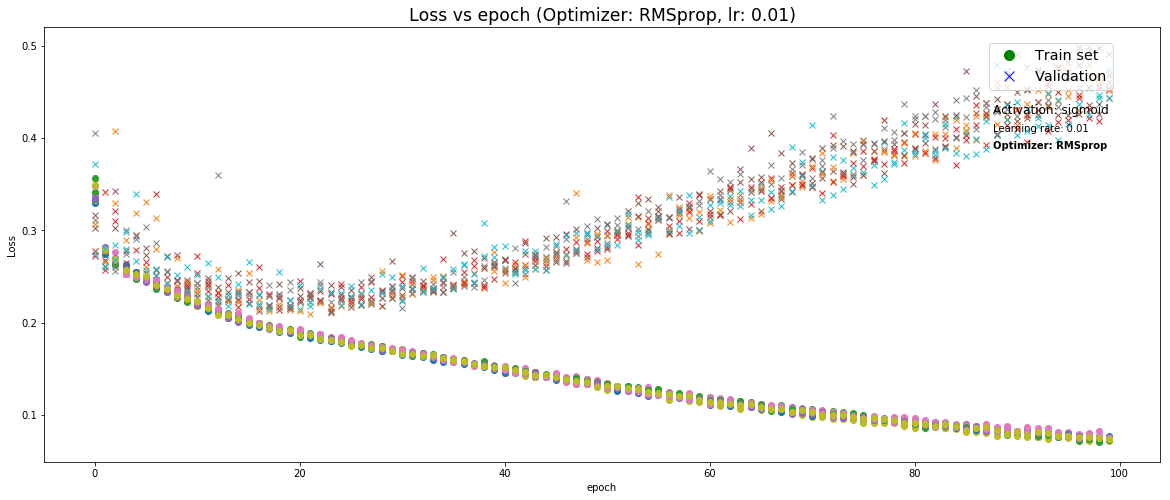

f1 score  (best model; sigmoid; RMSprop): 0.7879277977388032
f1 score (worst model; sigmoid; RMSprop): 0.7848017426748667





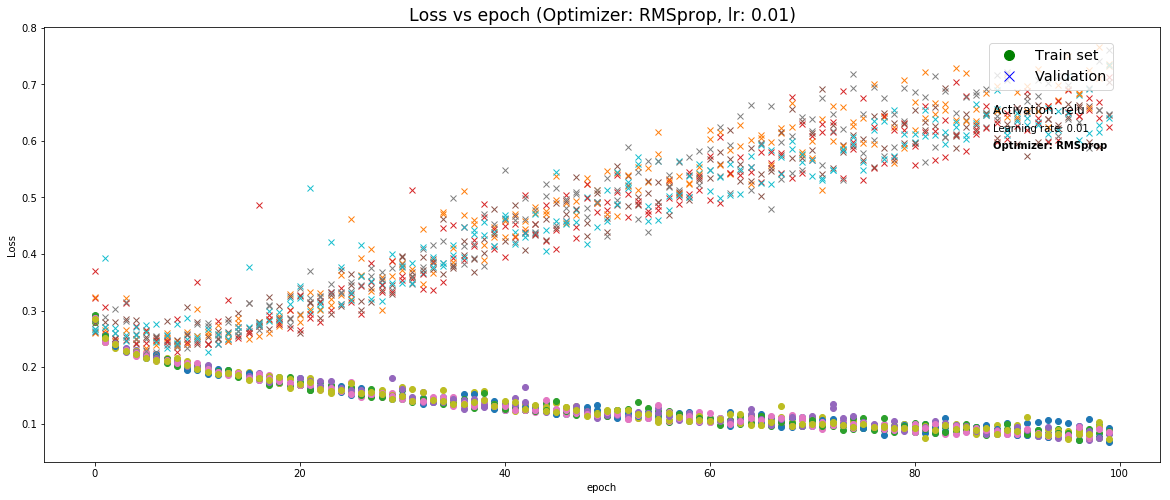

f1 score  (best model; relu; RMSprop): 0.8277064992695635
f1 score (worst model; relu; RMSprop): 0.8466214184091206


In [16]:
# RMSprop
txt = [{'x': 0.85, 'y': 0.76, 'txt': "Learning rate: 0.01", 'kw': {}},
       {'x': 0.85, 'y': 0.72, 'txt': "Optimizer: RMSprop", 'kw': {'weight': 'bold'}}]
title = "Loss vs epoch (Optimizer: RMSprop, lr: 0.01)"


model_sigmoid = plotModel(10, "sigmoid", RMSprop(lr=0.01), title=title, text=txt)
print("f1 score  (best model; sigmoid; RMSprop): {}".format(f1_score(y_test,model_sigmoid[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; sigmoid; RMSprop): {}\n\n\n".format(f1_score(y_test,model_sigmoid[1].predict_classes(X_test_scaled),average='weighted')))

model_relu = plotModel(10, "relu", RMSprop(lr=0.01), title=title, text=txt)
print("f1 score  (best model; relu; RMSprop): {}".format(f1_score(y_test,model_relu[0].predict_classes(X_test_scaled),average='weighted')))
print("f1 score (worst model; relu; RMSprop): {}".format(f1_score(y_test,model_relu[1].predict_classes(X_test_scaled),average='weighted')))

**i) Regularizadores clásicos $l_1$ y $l_2$**

In [0]:
#TODO rango de los parametros?

n_par = 10
l12_param = np.logspace(-6,0,n_par)

for p in l12_param:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "L1: {:.4e}".format(p), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ Activity Regularizer, L1 = {:.4e})".format(p)
    model_sigmoid = plotModel2(10, "sigmoid", SGD(lr=0.01), l1=l1(p), title=title, text=txt)
    model_relu = plotModel2(10, "relu", SGD(lr=0.01), l1=l1(p), title=title, text=txt)

In [0]:
for p in l12_param:
    txt = [{'x': 0.85, 'y': 0.76, 'txt': "L2: {:.4e}".format(p), 'kw': {'weight': 'bold'}}]
    title = "Loss vs epoch (w/ Kerner regularizer, L2 = {:.4e})".format(p)
    model_sigmoid = plotModel2(10, "sigmoid", SGD(lr=0.01), l2=l2(p), title=title, text=txt)
    model_relu = plotModel2(10, "relu", SGD(lr=0.01), l1=l1(p), title=title, text=txt)

**j)**

<a id="segundo"></a>
## 2. *Deep Networks*

<a id="tercero"></a>
## 3. Redes Convolucionales en Imágenes

<a id="cuarto"></a>
## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico